# Pattern Matrix Replacement

This this notebook we explore strategies to replace the ***Hit Correlation*** step of Konrad's pipeline, specifically the *patten matrix* algorithm previously used.

## Approach
I am thinking of two approaches. First, use a simple MLP to determine if two given points are *causally related* or not. To do this, the following tasks are required:
- [x] prepare the data such that each row contains the features (x,y,z,time/timeslice) of each pair of points (exluding self)
    - [ ] subtask here is to use PCA to reduce the dimensions and see if the network performs same/worse
- [X] create labels for training set ie. *1* of related and *0* otherwise (this hinges upon the fact that we can extract labels from *mc_info* table)
- [ ] visualize the results

The other approach is to treat this as an unsupervised learning task and use clustering to determine *related* points.

# Creating the "Pattern Matrix" Dataset

Since this step will essentially double the width of the dataset and square it's height, we will only use timeslice 665 (timeslice with the largest hits, as per the [exploration](notebooks/exploration.ipynb) conducted previously). The algorithm to generate the dataset is as follows:
1. create an empty dataframe to hold the `result`
2.iterate over original df with the row and index
    1. duplicate original df
    2. set value of `dup` columns to that of the row
    3. concat dup and original dfs (sideways) to create pairs
    4. drop the rows where `id1` is less than `id2` to avoid repeat pairs
    5. append dup to result
    
The algorithm was tested with a small sample of 10 rows before the dataset below was created.

## Generate labels

Once we "explode" the dataset, we need to generate labels. The logic is simple, if `eid1` and `eid2` are same then give it a label of 1, else a label of 0. There are 3 possible combinations that can occur: 1. hit-hit 2. hit-noise and 3. noise-noise. Since noise has `nan` for the event ids and since in Python `nan != nan` all 3 cases can be correctly handled by a simple comparison of the two column values.

Drop the columns that are not required for training, and write to csv.

# Alternative datasets

- [ ] train using the difference between x,y,z,t
- [ ] train using a larger sample (50%, 75%, 100% of slice-615)
- [ ] train using sample from entire dataset, across timeslices

# MLP for "Pattern Matrix" Replacement

I followed this [tutorial](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/) to implement the first iteration of the network.

## Experiment 1
To combat the shortcomings of Experiment 1, we equalize the targets in this experiment whilst keeping the parameters the sames. Use **scripts/train-slice-615-10-equal.csv** to generate the dataset.

### Parameters
- Data: 10% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 10

### Remarks
The model already performs well, but we can improve the performance with perhaps more data.

In [1]:
from context import km3net
from km3net.utils import DATADIR
import km3net.model.utils as model_utils
import km3net.model.eval as model_eval
import km3net.data.utils as data_utils
import km3net.data.pattern_matrix as pm
from km3net.model.mlp import MLP
from torch.nn import BCELoss
from torch.optim import SGD
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_path = DATADIR+'/train/slice-615-10-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 9253, valid size: 4557, test size: 364231
---
epochs: 0, train loss: 0.040, valid loss: 0.037
epochs: 5, train loss: 0.028, valid loss: 0.027
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

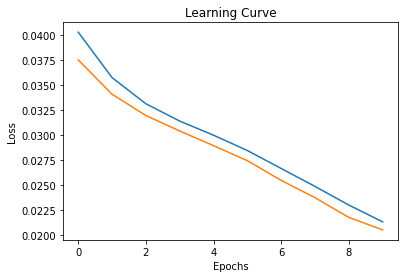

<Figure size 576x576 with 0 Axes>

In [3]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

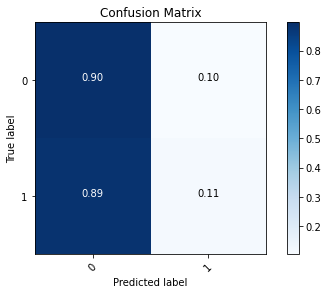

<Figure size 576x576 with 0 Axes>

In [4]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [5]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94    355859
         1.0       0.03      0.11      0.04      8372

    accuracy                           0.88    364231
   macro avg       0.50      0.51      0.49    364231
weighted avg       0.96      0.88      0.91    364231



## Experiment 2
Next, we increase the size of training set whilst keeping the parameters the same.

### Parameters
- Data: 25% of slice 615 (equalized classes)
- Loss: BCELoss
- Optimizer: SGD(lr=0.001, momentum=0.9)
- Layers: (8, 10), (10, 8)
- Activation: hidden -> ReLu, output -> Sigmoid
- Epochs: 5

### Remarks
The loss functions seem to converge, it either needs more data to train with or more epochs of training.

In [6]:
train_path = DATADIR+'/train/slice-615-25-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 10,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 42407, valid size: 20887, test size: 364231
---
epochs: 0, train loss: 0.039, valid loss: 0.033
epochs: 5, train loss: 0.012, valid loss: 0.011
---


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

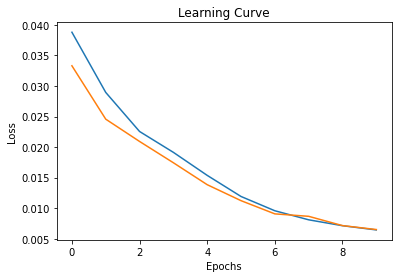

<Figure size 576x576 with 0 Axes>

In [7]:
model_eval.plot_learning_curve(results['train_losses'],
                                          results['valid_losses'])

Confusion matrix with normalization


<module 'matplotlib.pyplot' from '/home/ashome/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

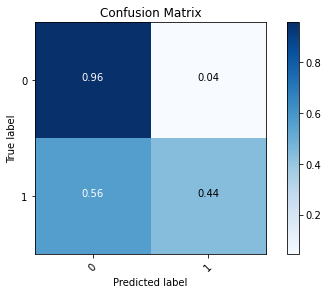

<Figure size 576x576 with 0 Axes>

In [8]:
matrix = confusion_matrix(results['y_true'], results['y_pred'])
model_eval.plot_confusion_matrix(matrix, classes=[0, 1], normalize=True)

In [9]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97    355859
         1.0       0.19      0.44      0.26      8372

    accuracy                           0.94    364231
   macro avg       0.59      0.70      0.62    364231
weighted avg       0.97      0.94      0.95    364231



## Experiment 2.1
Increase training epochs to 25

In [10]:
train_path = DATADIR+'/train/slice-615-25-equal.csv'
test_path = DATADIR+'/test/slice-1637-10.csv'
train_dl, valid_dl = model_utils.prepare_train_data(train_path,normalise=True)
test_dl = model_utils.prepare_test_data(test_path,normalise=True)
print("train size: {0}, valid size: {1}, test size: {2}".format(
    len(train_dl.dataset),len(valid_dl.dataset), len(test_dl.dataset)))

device = model_utils.get_device()
model = MLP(8).to(device)

params = {
    'model': model,
    'optimizer': SGD(model.parameters(), lr=0.001, momentum=0.9),
    'criterion': BCELoss(),
    'epochs': 25,
    'train_dl': train_dl,
    'valid_dl': valid_dl,
    'test_dl': test_dl
}

results = model_utils.evaluate(**params)

train size: 42407, valid size: 20887, test size: 364231
---
epochs: 0, train loss: 0.039, valid loss: 0.035
epochs: 5, train loss: 0.008, valid loss: 0.008
epochs: 10, train loss: 0.006, valid loss: 0.006
epochs: 15, train loss: 0.005, valid loss: 0.006
epochs: 20, train loss: 0.005, valid loss: 0.005
---


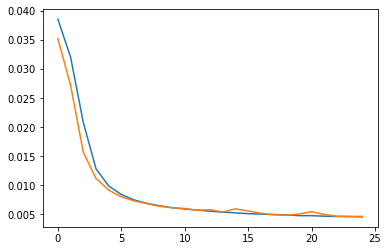

In [11]:
plt.plot(results['train_losses'])
plt.plot(results['valid_losses'])

In [12]:
matrix = confusion_matrix(results['y_true'],
                          results['y_pred'], normalize='all')
matrix

array([[0.95327416, 0.02374043],
       [0.01882047, 0.00416494]])

In [13]:
print(classification_report(results['y_true'], results['y_pred']))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    355859
         1.0       0.15      0.18      0.16      8372

    accuracy                           0.96    364231
   macro avg       0.56      0.58      0.57    364231
weighted avg       0.96      0.96      0.96    364231

